Copyright (C) 2023 Ming-Fong Sie <seansie07@gmail.com> & Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [1]:
# Import all used packages

import argparse
import collections
import json
import numpy as np
import os
import pandas as pd
import pickle
import sys
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score  # Add this import statement at the beginning

from tqdm import tqdm

from learn import get_model, get_params
from utils import run_from_ipython, np2df
from viz import show_cm_list, show_rp_list

if run_from_ipython():
    import matplotlib
    # %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    import xgboost
    sns.set_context('notebook')  # 'notebook', 'paper', 'talk', 'poster'
    # sns.set_style('dark')  # None, 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

In [2]:
# Parse Arguments

def parse(args=None):
    parser = argparse.ArgumentParser(
        prog='Classification',
        description='Train and test a machine learning classification method on the extracted features.'
    )
    parser.add_argument('--n_folds', help='n folds cross validation', type=int, default=10)
    parser.add_argument('--model', '-m', help='model/method', type=str,
                        choices=['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'], default='xgb')
    parser.add_argument('--feature_type', '-f',
                        help='feature type ("b" | "e" | "m" | "p" or "if4", "if5", "if10", "if13", "if20", "if64")',
                        type=str, default='bemp')
    parser.add_argument('--scheme', '-s', help='data scheme', type=str,
                        choices=['address', 'entity'], default='address')
    parser.add_argument('--n_jobs', '-j', help='number of workers/threads; set -1 to use all processors', type=int, default=10)
    parser.add_argument('--no_cost_sentitive', help='disable cost sentitive learning', action='store_true')
    parser.add_argument('--output', '-o', help='output path', type=str, default='./data_p')
    parser.add_argument('--result', '-r', help='result path', type=str, default='./result')
    return parser.parse_args() if args is None else parser.parse_args(args)
args = parse([]) if run_from_ipython() else parse()
print(args)

Namespace(feature_type='bemp', model='xgb', n_folds=10, n_jobs=10, no_cost_sentitive=False, output='./data_p', result='./result', scheme='address')


In [3]:
# Define the experiment setting

n_folds = args.n_folds                       # 10
model = args.model                           # 'lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'
feature_type = args.feature_type             # 'b' | 'e' | 'm' or 'if4', 'if5', 'if10', 'if13', 'if20', 'if64'
scheme = args.scheme                         # 'address', 'entity'
n_jobs = args.n_jobs                         # -1 to use all processors, or any positive integer
cost_sensitive = not args.no_cost_sentitive  # True, False
output_path = args.output
result_path = args.result

# Check the experiment setting

assert model in ['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb']
assert not feature_type.startswith('if') and len(feature_type) > 0 or \
       feature_type.startswith('if') and feature_type[2:].isdigit()
# assert scheme in ['address', 'entity']
assert scheme in ['address']

# Show the experiment setting

print('Experiment Setting')
print('===> Model:         ', model)
print('===> Feature Types: ', feature_type)
print('===> Data Scheme:   ', scheme)
print('===> Cost Sensitive:', cost_sensitive)
print('===> N Threads:     ', n_jobs)

Experiment Setting
===> Model:          xgb
===> Feature Types:  bemp
===> Data Scheme:    address
===> Cost Sensitive: True
===> N Threads:      10


In [4]:
# Load transaction history summarization data

# data_file = 'data.{}.csv'.format(scheme)
# data_file = 'nanzero_data.{}.csv'.format(scheme)
# data_file = 'quantum_qubo_data.{}.csv'.format(scheme)
data_file = 'all_selected_features_QA_data.{}.csv'.format(scheme)
data = pd.read_csv(os.path.join(output_path, data_file))
print (data)
if run_from_ipython():
    data.head(4)
else:
    print(data.head(4))

         n_tx  total_days  total_spent_btc  total_received_btc  \
0           0        78.0                0                   0   
1           0        63.0                0                   0   
2           0         1.0                0                   0   
3           0         1.0                0                   0   
4           0         1.0                0                   0   
...       ...         ...              ...                 ...   
1857029     0         1.0                0                   0   
1857030     0         1.0                0                   0   
1857031     0         6.0                0                   0   
1857032     0         1.0                0                   0   
1857033     0         1.0                0                   0   

         total_spent_usd  total_received_usd  mean_balance_btc  \
0                      0                   0          0.087697   
1                      0                   0          3.271261   
2        

In [5]:
# Define 4 types of features (basic statistics, extra statistics, moments and patterns)

basic = [
    'f_tx', 'f_received', 'f_coinbase',
    'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
    'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
    'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
    'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
    'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
    'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
]
extra = [
    'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
    'total_spent_btc', 'total_received_btc',
    'total_spent_usd', 'total_received_usd',
    'mean_balance_btc', 'std_balance_btc',
    'mean_balance_usd', 'std_balance_usd'
]
moments = [
    'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
    'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
    'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
    'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
    'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
    'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
]
patterns =[
    'tx_input', 'tx_output',
    'n_multi_in', 'n_multi_out', 'n_multi_in_out'
]

features = []
if not feature_type.startswith('if') and len(feature_type) > 0:
    if 'b' in feature_type:
        features += basic
    if 'e' in feature_type:
        features += extra
    if 'm' in feature_type:
        features += moments
    if 'p' in feature_type:
        features += patterns
        print("Patterns included:", patterns)
elif feature_type.startswith('if') and feature_type[2:].isdigit():
    """
    Important features from LightGBM with BEM
    [ 0 25 24 29 40 37 27 23 56 36  1 28 26 57 32 38 44 45 33 18 39 60 53 35
     34 52 41 17 14 15 16 19 42  5  6 47  7 46  2 54  4 43  8 59 58 55  9 13
     61 48  3 31 10 62 20 21 63 30 49 11 51 50 22 12]
    """
    all_features = basic + extra + moments
    if_indices = [
        0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
        1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
        39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
        16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
        4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
        3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
        51, 50, 22, 12
    ]
    if_features = [all_features[i] for i in if_indices]
    n_if = int(feature_type[2:])
    features = if_features[:n_if]
else:
    raise Exception('Invalid feature types: {:s}'.format(feature_type))

invalid_features = [feature for feature in features if feature not in data.columns]
assert len(invalid_features) == 0, 'Invalid features: ' + ', '.join(invalid_features)

X = data.get(features).values
y = data['class'].values
print (features)
print (feature_type)
print (X)
print (y)

class2label = json.loads(open(os.path.join(output_path, 'class2label.json'), 'r').read())
label2class = json.loads(open(os.path.join(output_path, 'label2class.json'), 'r').read())
class_names = np.array([label2class[i] for i in range(6)])
print (class_names)
y_names = class_names
# y_names = class_names[y]
# y_names = np.array(class_names)[y.astype(int)]

print(len(X), len(y), len(features))

os.makedirs(result_path, exist_ok=True)

Patterns included: ['tx_input', 'tx_output', 'n_multi_in', 'n_multi_out', 'n_multi_in_out']
['f_tx', 'f_received', 'f_coinbase', 'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0', 'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4', 'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2', 'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2', 'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6', 'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent', 'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback', 'total_spent_btc', 'total_received_btc', 'total_spent_usd', 'total_received_usd', 'mean_balance_btc', 'std_balance_btc', 'mean_balance_usd', 'std_balance_usd', 'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment', 'dist_total_1st_moment', 'dist_total_2nd_moment', 'di

In [6]:
# def data_distribution(df):
#     if run_from_ipython():
#         plt.figure()
#         sns.countplot(df.index)
#     cnt = collections.Counter(df.index)
#     print(cnt)
#     return np.array([cnt[i] for i in range(len(cnt))])

# print(class2label)
# data_dict = np2df(X, y)
# print(data_dict)
# y_count = data_distribution(data_dict)
# # y_count = data_distribution(np2df(X, y))

In [7]:
# Training procedure

train_cm_list = []
train_rp_list = []
valid_cm_list = []
valid_rp_list = []
fi_list = []

# Add these lists to store AUC scores
train_auc_list = []
valid_auc_list = []

# Model parameters
clf_params = get_params(model)
if model not in ['ab', 'svm']:
    clf_params['n_jobs'] = n_jobs
print('Hyper-parameters:')
print(clf_params)

# Declare K-Fold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Normalize data
# Note that decision tree sbased algorithms need no data normalization
if model in ['lr', 'p', 'svm']:
    print('Normalizing data...')
    X = np.nan_to_num(X / np.abs(X).max(axis=0))

# Start cross validation
for train_idx, valid_idx in tqdm(skf.split(X, y)):
    # print(train_idx[:100], valid_idx[:10])
    
    # Retrieve splitted training set and validating set
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Calculate sample weight (whether to apply cost sensitive learning)
    sample_weight = np.ones((len(y_train), ), dtype='float64')
    if cost_sensitive:
        sample_weight = class_weight.compute_sample_weight('balanced', y_train)
    
    # Declare the classifier and train it on the training set
    clf = get_model(model, clf_params)
    # clf.fit(X_train, y_train)
    clf.fit(X_train, y_train, sample_weight=sample_weight)
    
    # Evaluate on the training set
    y_pred = clf.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    train_cm_list.append(cm)
    rp = classification_report(y_train, y_pred, target_names=class_names, output_dict=True)
    train_rp_list.append(rp)
    
    # Evaluate on the validating set
    y_pred = clf.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    valid_cm_list.append(cm)
    rp = classification_report(y_valid, y_pred, target_names=class_names, output_dict=True)
    valid_rp_list.append(rp)
    
    # Get the feature importances according to the trained model
    if model in ['rf', 'xgb', 'lgb']:
        if 'booster' in clf_params and clf_params['booster'] == 'dart':
            pass
        else:
            fi = clf.feature_importances_
            fi_list.append(fi)
            
    # Calculate AUC for the training set
    y_train_prob = clf.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_train_prob, multi_class="ovr", average="macro")
    train_auc_list.append(train_auc)

    # Calculate AUC for the validation set
    y_valid_prob = clf.predict_proba(X_valid)
    valid_auc = roc_auc_score(y_valid, y_valid_prob, multi_class="ovr", average="macro")
    valid_auc_list.append(valid_auc)

Hyper-parameters:
{'n_estimators': 1000, 'importance_type': 'gain', 'n_jobs': 10}


10it [1:06:54, 401.44s/it]


In [21]:
# Save training results

experiment_name = os.path.join(result_path, '{}.{}.{}'.format(model, feature_type, scheme))
if not cost_sensitive:
    experiment_name += '.no_cs'
results = {
    'train_cm_list': train_cm_list,
    'valid_cm_list': valid_cm_list,
    'train_rp_list': train_rp_list,
    'valid_rp_list': valid_rp_list,
    'fi_list': fi_list,
    'train_auc_list': train_auc_list,
    'valid_auc_list': valid_auc_list
}
pickle.dump(results, open(experiment_name + '.pkl', 'wb'))

# Save model
model_save_path = '{}_model.pkl'.format(experiment_name)
with open(model_save_path, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Results and model saved to {result_path}")

Results and model saved to ./result


Average confusion matrix of training set in 10-fold


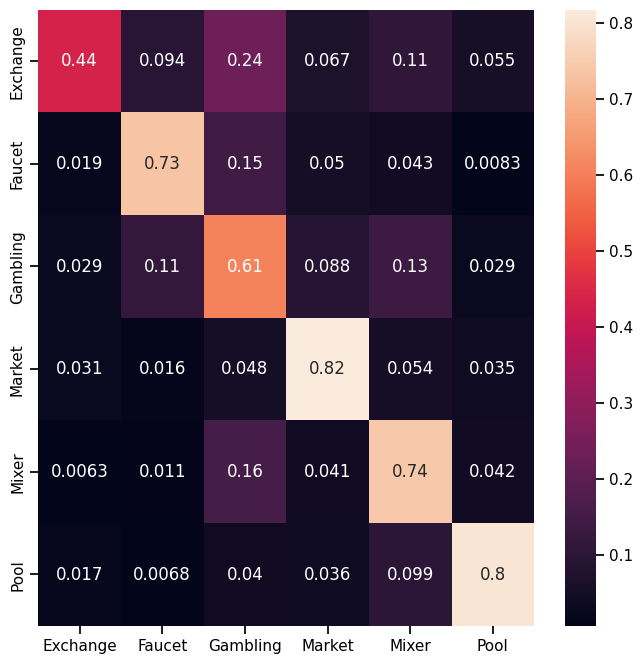

In [9]:
# Average confusion matrix of training set in K-fold

print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(train_cm_list, class_names)

In [10]:
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    summed_metrics = {}
    summed_accuracy = 0
    summed_category_accuracies = {category: 0 for category in class_names}
    category_supports = {category: 0 for category in class_names}

    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if isinstance(metrics, dict) and category in class_names:
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        summed_metrics[category][metric] += value
                category_supports[category] += metrics.get('support', 0)

        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    avg_metrics = {}
    total_support = sum(category_supports.values())
    macro_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}
    weighted_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}

    for category, metrics in summed_metrics.items():
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        for metric in macro_avg:
            macro_avg[metric] += avg_metrics[category][metric] / len(class_names)
            weighted_avg[metric] += (avg_metrics[category][metric] * category_supports[category]) / total_support

    avg_accuracy = summed_accuracy / len(rp_list)
    avg_category_accuracies = {category: acc / len(cm_list) for category, acc in summed_category_accuracies.items()}

    print(f"Overall Accuracy: {avg_accuracy}\n")
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value}")
        print(f"  Accuracy: {avg_category_accuracies[category]}\n")

    print("Category: macro avg")
    for metric, value in macro_avg.items():
        print(f"  {metric}: {value}")
    print("\nCategory: weighted avg")
    for metric, value in weighted_avg.items():
        print(f"  {metric}: {value}")

# Assuming n_folds, train_rp_list, train_cm_list, and class_names are defined elsewhere
print('Average classification report and accuracies of training set in {:d}-fold'.format(n_folds))
show_rp_list_and_accuracies(train_rp_list, train_cm_list, class_names)


Average classification report and accuracies of training set in 10-fold
Overall Accuracy: 0.5385227195480328

Category: Exchange
  precision: 0.9773439107533297
  recall: 0.43677003462636843
  f1-score: 0.6037339229353809
  Accuracy: 0.889060973948251

Category: Faucet
  precision: 0.12796353012357606
  recall: 0.7346328488193674
  f1-score: 0.21795885142965296
  Accuracy: 0.9153935147005452

Category: Gambling
  precision: 0.2570799571160296
  recall: 0.6055092712376023
  f1-score: 0.3609220868942923
  Accuracy: 0.830005109829736

Category: Market
  precision: 0.4278323990726406
  recall: 0.8170015930103858
  f1-score: 0.561583109769216
  Accuracy: 0.9225617471225844

Category: Mixer
  precision: 0.5697124966547074
  recall: 0.7437753637934518
  f1-score: 0.6452069025204785
  Accuracy: 0.8842195777174762

Category: Pool
  precision: 0.30057039005348013
  recall: 0.8024623091828536
  f1-score: 0.43732182333686537
  Accuracy: 0.9388095502380838

Category: macro avg
  precision: 0.443417

Average confusion matrix of validataion set in 10-fold


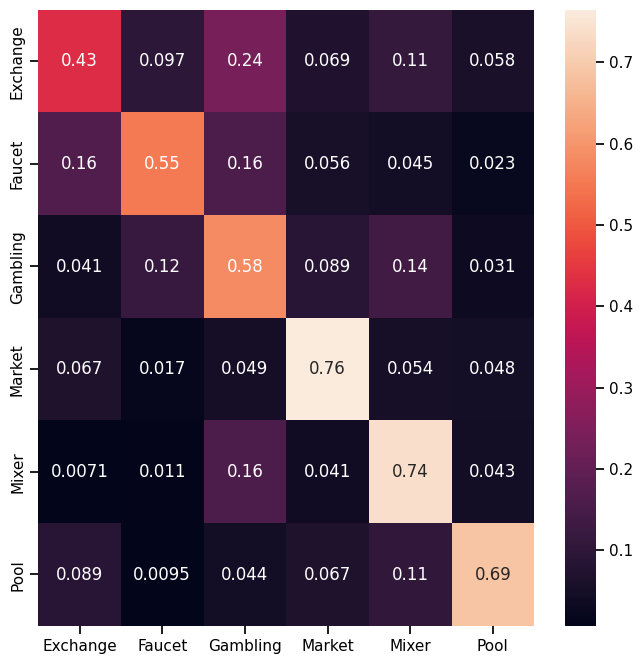

In [11]:
# Average confusion matrix of validataion set in K-fold

print('Average confusion matrix of validataion set in {:d}-fold'.format(n_folds))
show_cm_list(valid_cm_list, class_names)

Average classification report of validation set in 10-fold


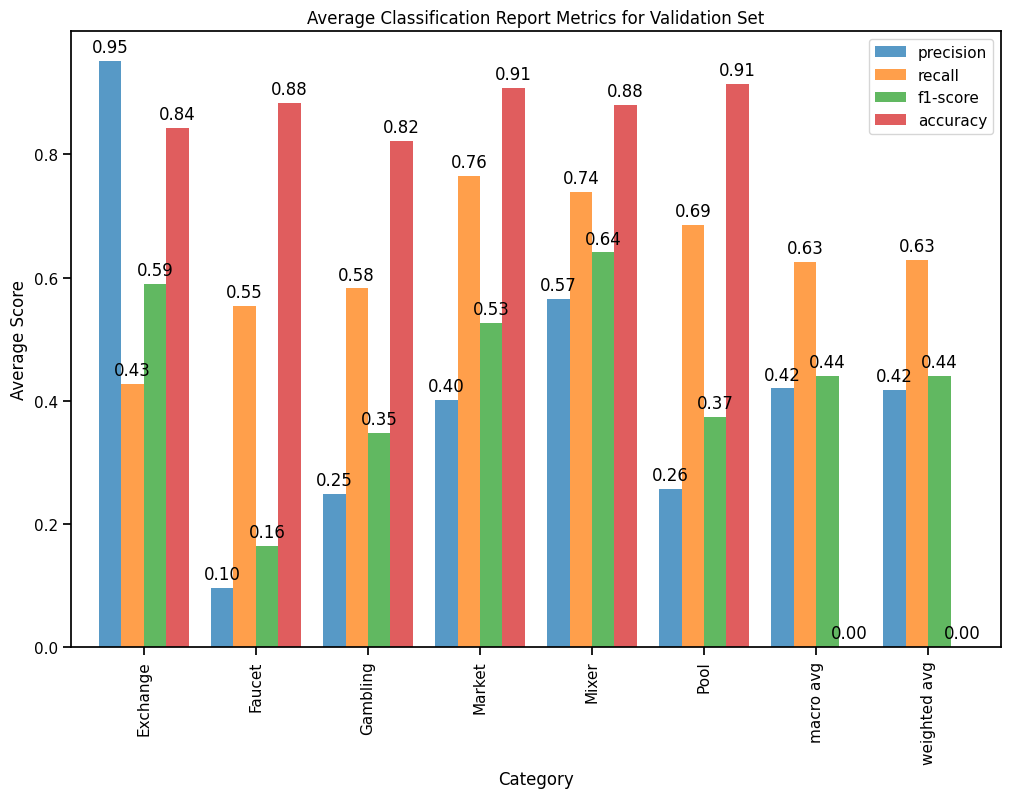

In [12]:
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    class_names_list = list(class_names)  # Convert class_names to a list for index access
    summed_metrics, avg_metrics = {}, {}
    summed_category_accuracies = {category: 0 for category in class_names}
    summed_accuracy = 0

    for report in rp_list:
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if category in class_names_list and isinstance(metrics, dict):
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        summed_metrics[category][metric] += value

    for cm in cm_list:
        for i, category in enumerate(class_names_list):
            if category in summed_metrics:  # Ensure category exists in the metrics dictionary
                TP = cm[i, i]
                TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
                FP = cm[:, i].sum() - TP
                FN = cm[i, :].sum() - TP
                accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
                summed_category_accuracies[category] += accuracy

    # Calculate average metrics and accuracies
    for category in class_names_list:
        if category in summed_metrics:
            avg_metrics[category] = {metric: summed_metrics[category][metric] / len(rp_list) for metric in ['precision', 'recall', 'f1-score']}
    
    # Calculate macro and weighted averages
    macro_avg = {metric: sum(avg_metrics[cat][metric] for cat in class_names_list) / len(class_names_list) for metric in ['precision', 'recall', 'f1-score']}
    weighted_avg = {metric: sum(avg_metrics[cat][metric] * summed_category_accuracies[cat] for cat in class_names_list) / sum(summed_category_accuracies.values()) for metric in ['precision', 'recall', 'f1-score']}
    
    # Append macro and weighted averages to avg_metrics
    avg_metrics['macro avg'] = macro_avg
    avg_metrics['weighted avg'] = weighted_avg

    avg_accuracy = summed_accuracy / len(rp_list) if len(rp_list) > 0 else 0
    avg_category_accuracies = {category: summed_category_accuracies[category] / len(cm_list) for category in class_names_list}

    return avg_metrics, avg_category_accuracies, avg_accuracy

# Assuming necessary variables (n_folds, valid_rp_list, valid_cm_list, class_names) are defined
print('Average classification report of validation set in {:d}-fold'.format(n_folds))
avg_metrics, avg_category_accuracies, avg_accuracy = show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)

df_averages = pd.DataFrame(avg_metrics).T
df_averages['accuracy'] = pd.Series(avg_category_accuracies)

ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics for Validation Set')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


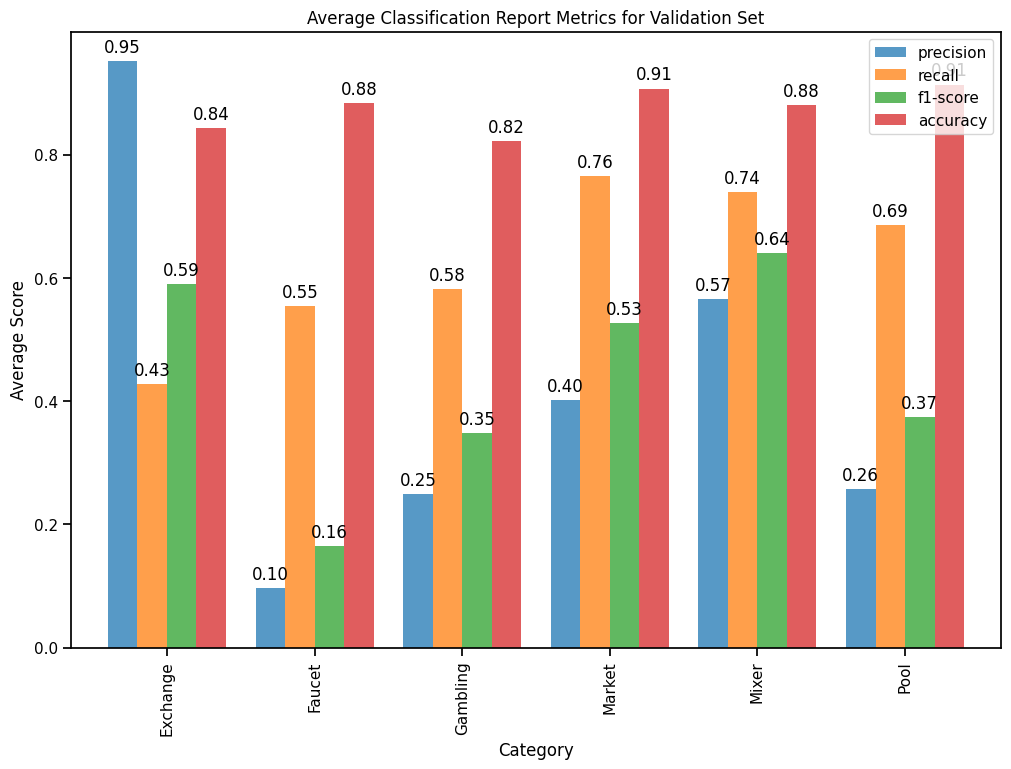

In [13]:
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    # Initialize dictionaries for summed and average metrics
    summed_metrics, avg_metrics = {}, {}
    summed_category_accuracies, avg_category_accuracies = {}, {}
    summed_accuracy = 0

    # Initialize summed metrics and accuracies
    for category in class_names:
        summed_metrics[category] = {'precision': 0, 'recall': 0, 'f1-score': 0}
        summed_category_accuracies[category] = 0

    # Iterate over reports and confusion matrices
    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            # Skip 'accuracy', 'macro avg', and 'weighted avg' categories
            if category in ['accuracy', 'macro avg', 'weighted avg']:
                if category == 'accuracy':
                    summed_accuracy += metrics
                continue

            # Sum metrics for each category
            for metric in ['precision', 'recall', 'f1-score']:
                if metric in metrics:
                    summed_metrics[category][metric] += metrics[metric]

        # Calculate and sum category-specific accuracies
        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    # Calculate average metrics and accuracies
    for category in class_names:
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in summed_metrics[category].items()}
        avg_category_accuracies[category] = summed_category_accuracies[category] / len(cm_list)
    avg_accuracy = summed_accuracy / len(rp_list)

    # Return average metrics and accuracies
    return avg_metrics, avg_category_accuracies, avg_accuracy

# Use the function for validation set and get the data for plotting
avg_metrics, avg_category_accuracies, avg_accuracy = show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)

# Prepare DataFrame for plotting
df_averages = pd.DataFrame(avg_metrics).T
df_averages['accuracy'] = pd.Series(avg_category_accuracies)

# Plotting
ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics for Validation Set')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

# Add value labels to each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


gain
[36 65  0 68 52 40 27 62 47  1 20 17 18 19 22 21 15 23 24 25 26 16 64 14
 29 13 12 11 10  9  8  7  6  5  4  3  2 28 32 30 31 61 60 59 58 57 56 55
 54 53 51 50 49 48 46 45 44 43 42 41 39 38 37 66 35 67 33 63 34]


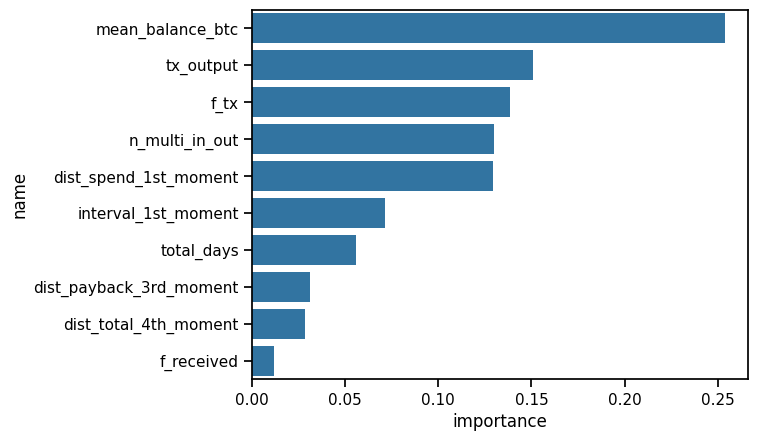

In [14]:
# Feature Importance

if len(fi_list) == 0:
    exit()
    sys.exit()

try:
    print(clf.importance_type)
except Exception as e:
    print(e)

fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_top_10 = df_feature_importances.nlargest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_top_10)  # Modified this line


In [15]:
if run_from_ipython():
    plt.figure(figsize=(16, 32))
    for i in range(10):
        feature_index = df_top_10.index[i]
        feature_name = list(df_top_10['name'])[i]
        feature_data = X[:, feature_index]

        # Check if the lengths match
        if len(y_names) != len(feature_data):
            print(f"Length mismatch for feature '{feature_name}': Length of y_names is {len(y_names)}, length of feature data is {len(feature_data)}")
            continue  # Skip this iteration

        plt.subplot(5, 2, i+1)
        plt.title(feature_name)
        ax = sns.boxplot(x=y_names, y=feature_data)


Length mismatch for feature 'mean_balance_btc': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'tx_output': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'f_tx': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'n_multi_in_out': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'dist_spend_1st_moment': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'interval_1st_moment': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'total_days': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'dist_payback_3rd_moment': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'dist_total_4th_moment': Length of y_names is 6, length of feature data is 1857034
Length mismatch for feature 'f_received': Length of y

<Figure size 1600x3200 with 0 Axes>

[36 65  0 68 52 40 27 62 47  1 20 17 18 19 22 21 15 23 24 25 26 16 64 14
 29 13 12 11 10  9  8  7  6  5  4  3  2 28 32 30 31 61 60 59 58 57 56 55
 54 53 51 50 49 48 46 45 44 43 42 41 39 38 37 66 35 67 33 63 34]


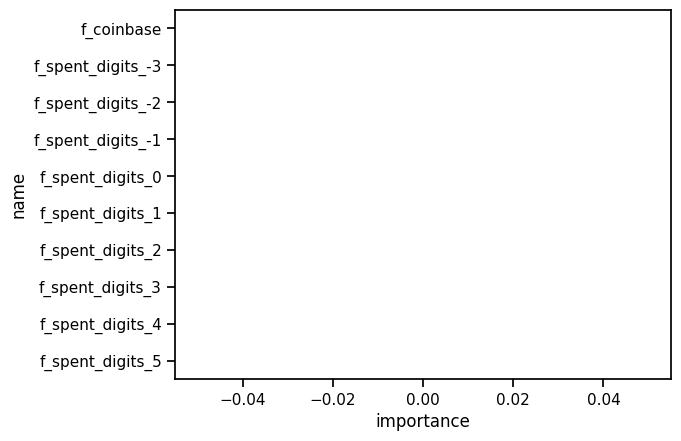

In [16]:
fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_least_10 = df_feature_importances.nsmallest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_least_10)  # Corrected this line


[36 65  0 68 52 40 27 62 47  1 20 17 18 19 22 21 15 23 24 25 26 16 64 14
 29 13 12 11 10  9  8  7  6  5  4  3  2 28 32 30 31 61 60 59 58 57 56 55
 54 53 51 50 49 48 46 45 44 43 42 41 39 38 37 66 35 67 33 63 34]


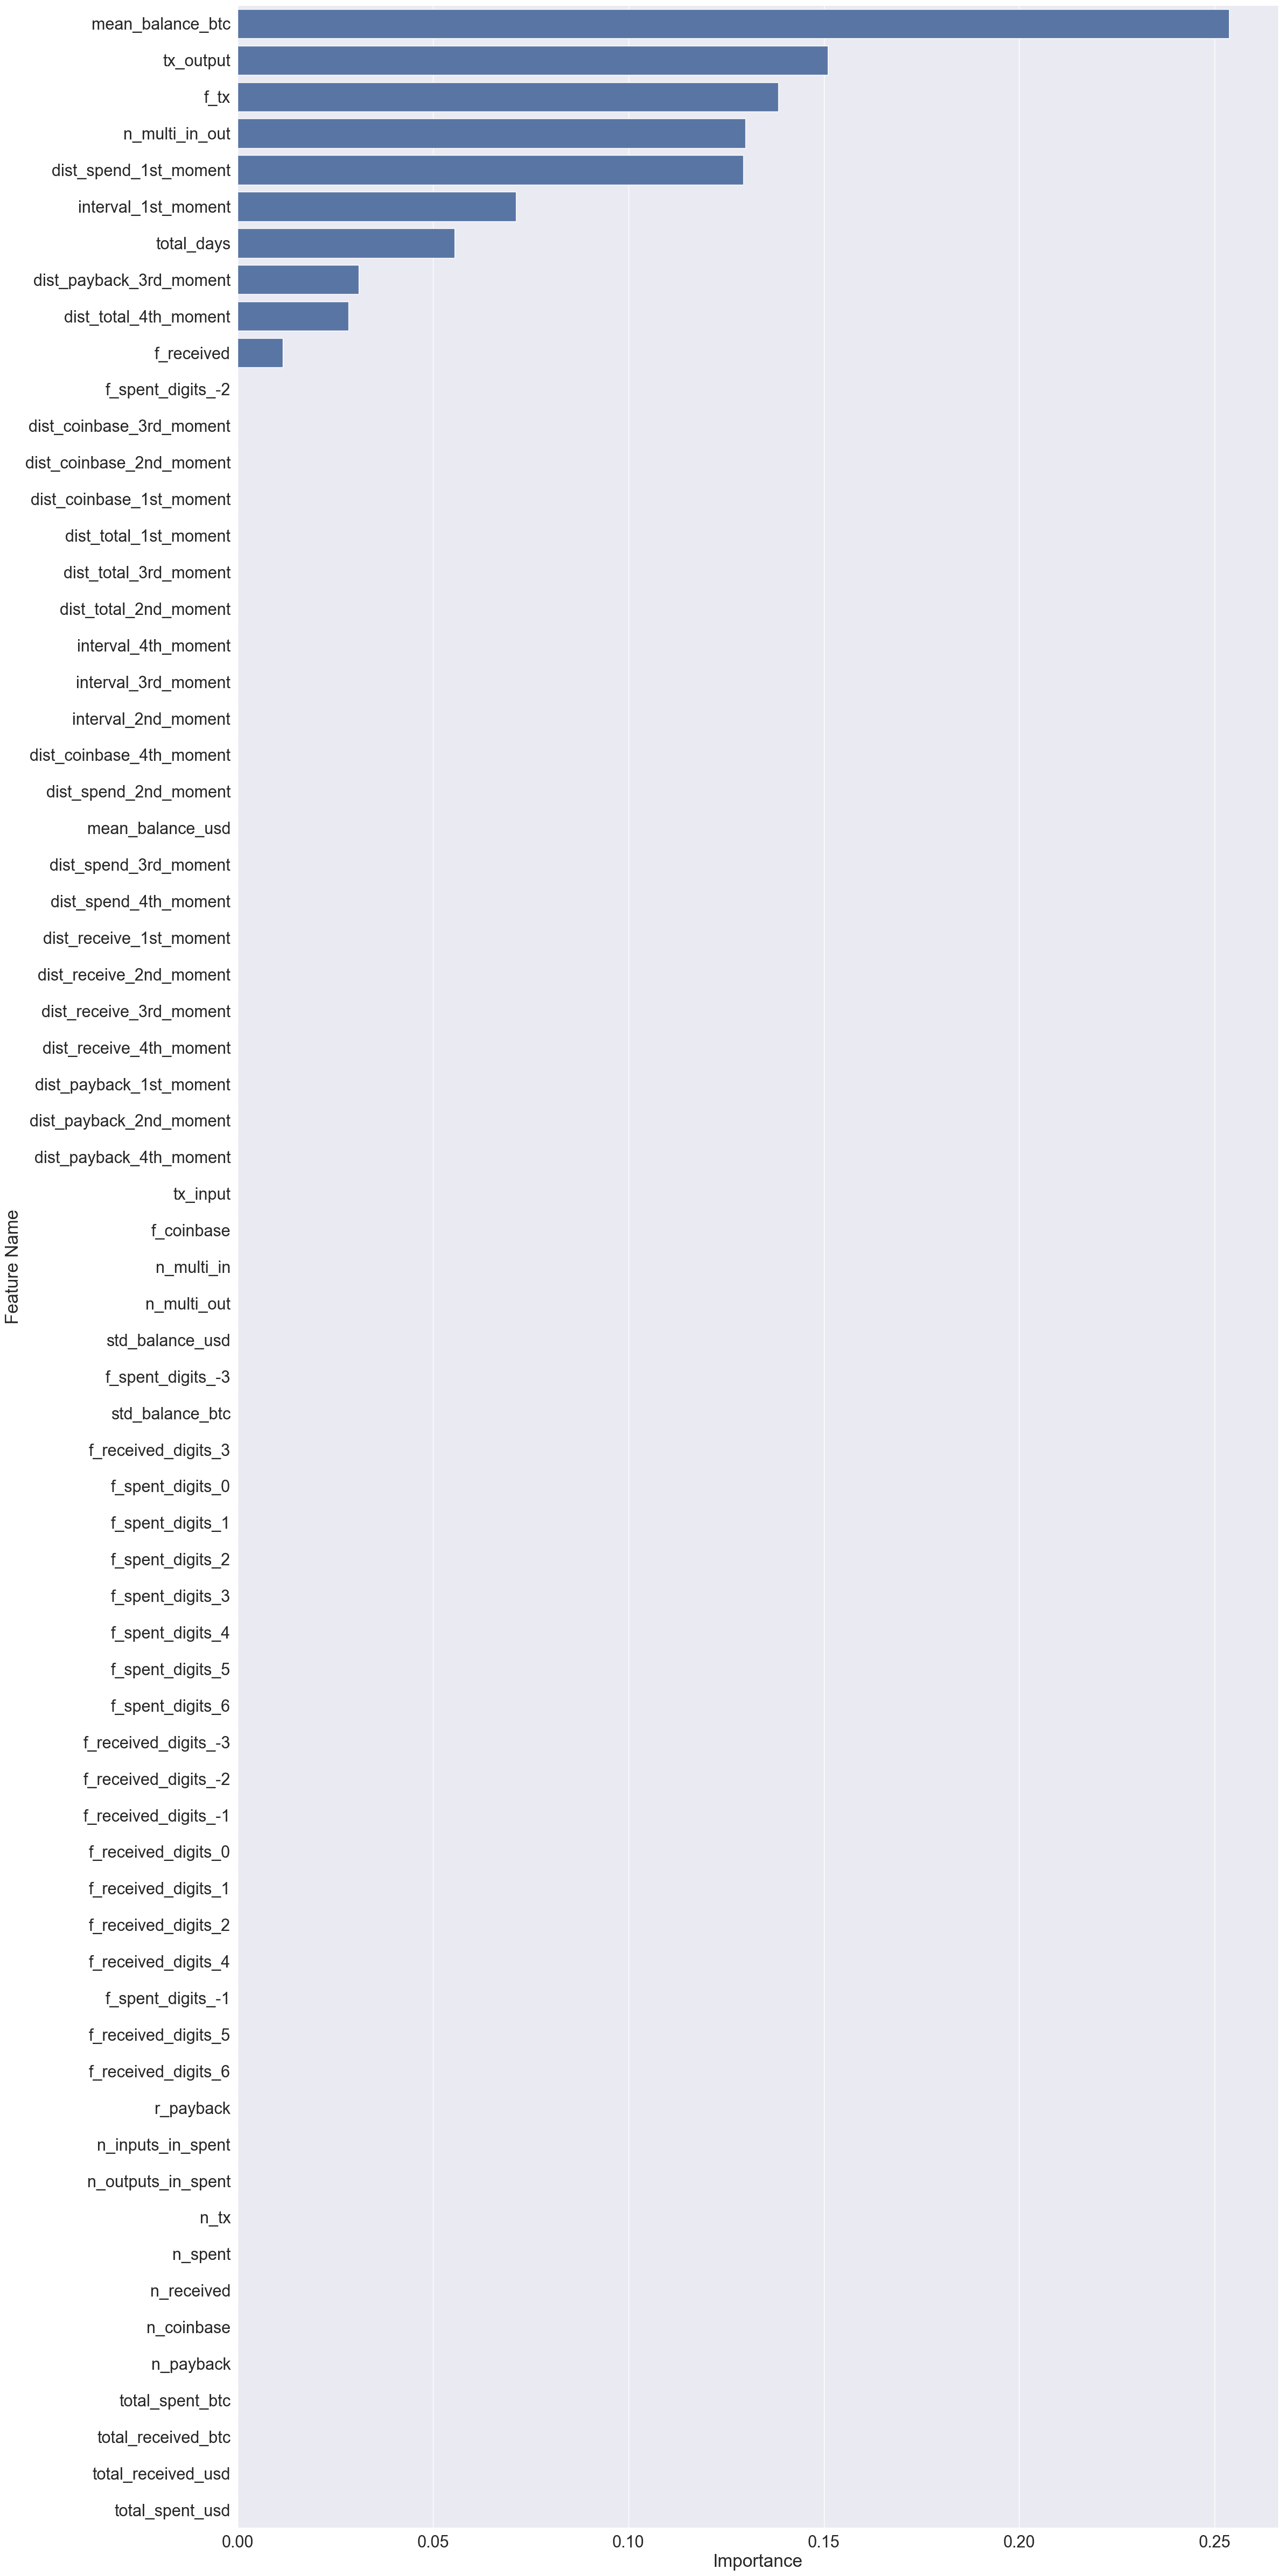

In [17]:
fi_avg = np.mean(fi_list, axis=0)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'Feature Name': features, 'Importance': fi_avg})
    df_least_10 = df_feature_importances.nlargest(len(features), columns='Importance')
    plt.figure(figsize=(24, 48))
    sns.set(font_scale=2)
    sns.barplot(x='Importance', y='Feature Name', data=df_least_10)  # Corrected this line
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('top_10_and_last_10_feature_importance.png')  # Uncomment this line to save the figure


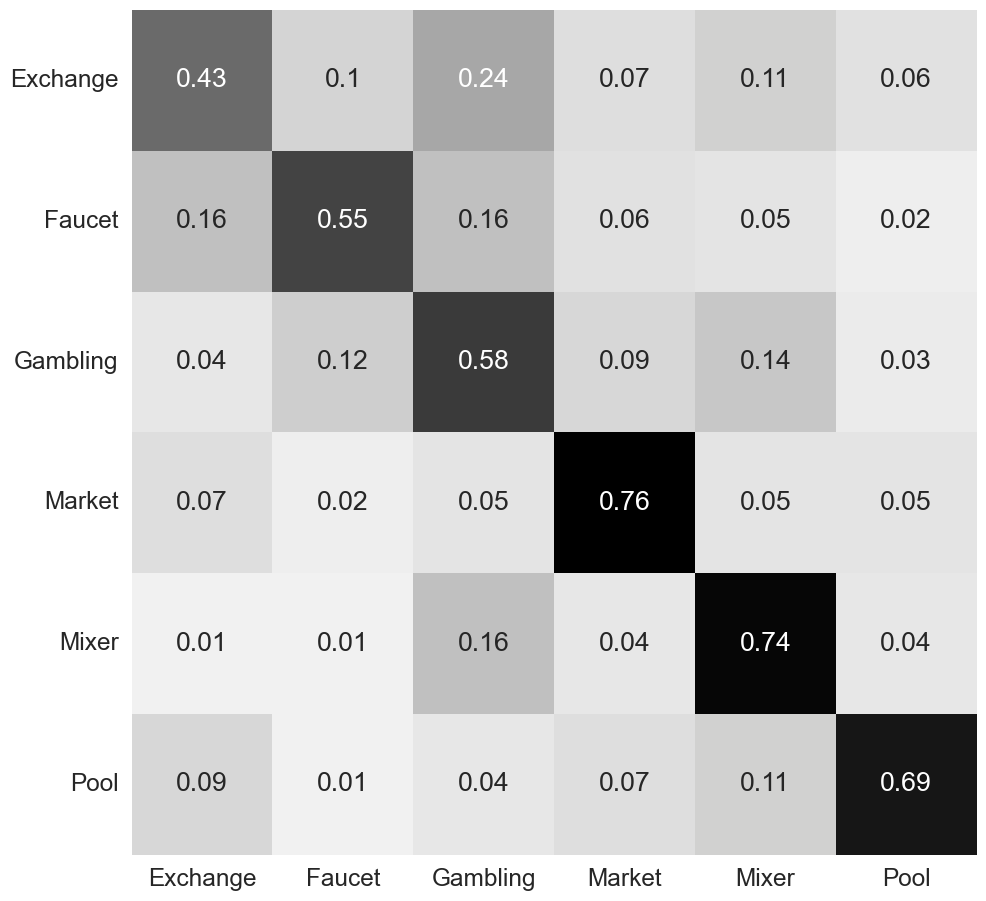

In [18]:
from matplotlib.colors import ListedColormap

cm_avg = np.mean(valid_cm_list, axis=0)
# print(cm_avg)
if run_from_ipython():
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 10))
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.light_palette('black', as_cmap=True)
    # cmap = ListedColormap(['white'])
    sns.set(font_scale=1.6)
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('confusion_matrix.png')  # Uncomment this line to save the figure

Average Training Confusion Matrix:
[[0.43677003 0.09396257 0.2362589  0.06678865 0.11073042 0.05548942]
 [0.0191684  0.73463285 0.14508419 0.05023501 0.04254442 0.00833513]
 [0.02911427 0.11490068 0.60550927 0.08814144 0.13308668 0.02924766]
 [0.03123066 0.01564144 0.04772613 0.81700159 0.05358038 0.0348198 ]
 [0.0063069  0.01099928 0.15651856 0.04068691 0.74377536 0.04171299]
 [0.01658396 0.00676781 0.03989083 0.0357791  0.098516   0.80246231]]

Average Validation Confusion Matrix:
[[0.42741609 0.09701584 0.23715431 0.06930473 0.11106262 0.05804641]
 [0.16419229 0.55354193 0.15853633 0.05573956 0.04500238 0.02298751]
 [0.04051746 0.11889263 0.58238551 0.08856404 0.13842173 0.03121863]
 [0.06711121 0.01690023 0.0488598  0.76453302 0.05409824 0.0484975 ]
 [0.00707692 0.01119567 0.15893386 0.04070396 0.73939462 0.04269497]
 [0.08925989 0.00948533 0.043641   0.06748192 0.10510421 0.68502765]]

Average Train AUC: 0.904839427555326
Average Valid AUC: 0.8766871709966308


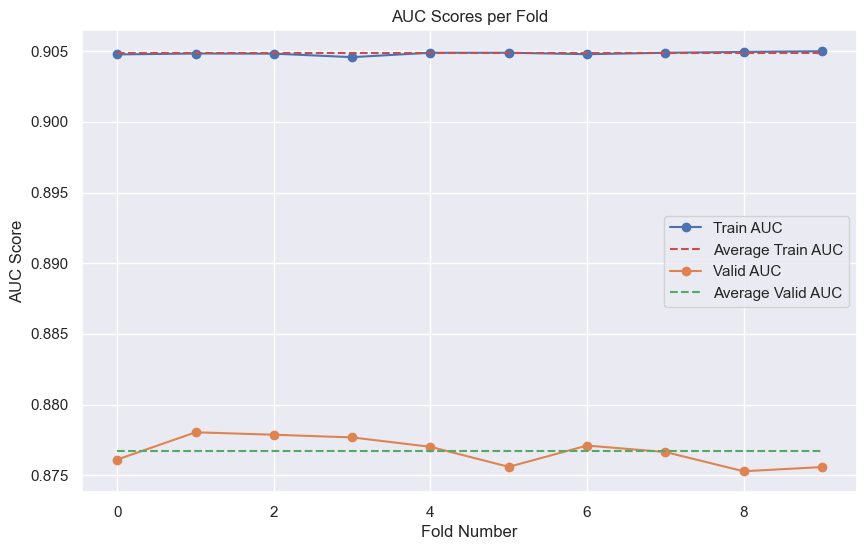

In [19]:
import matplotlib.pyplot as plt

# 计算平均混淆矩阵
avg_train_cm = np.mean(train_cm_list, axis=0)
avg_valid_cm = np.mean(valid_cm_list, axis=0)

# 计算平均AUC分数
avg_train_auc = np.mean(train_auc_list)
avg_valid_auc = np.mean(valid_auc_list)

# 展示平均混淆矩阵
print("Average Training Confusion Matrix:")
print(avg_train_cm)
print("\nAverage Validation Confusion Matrix:")
print(avg_valid_cm)

# 展示平均AUC分数
print(f"\nAverage Train AUC: {avg_train_auc}")
print(f"Average Valid AUC: {avg_valid_auc}")

# 绘制AUC分数图表
plt.figure(figsize=(10, 6))
plt.plot(train_auc_list, label='Train AUC', marker='o')
plt.plot([avg_train_auc] * len(train_auc_list), 'r--', label='Average Train AUC')
plt.plot(valid_auc_list, label='Valid AUC', marker='o')
plt.plot([avg_valid_auc] * len(valid_auc_list), 'g--', label='Average Valid AUC')
plt.title('AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_14112\1393660083.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


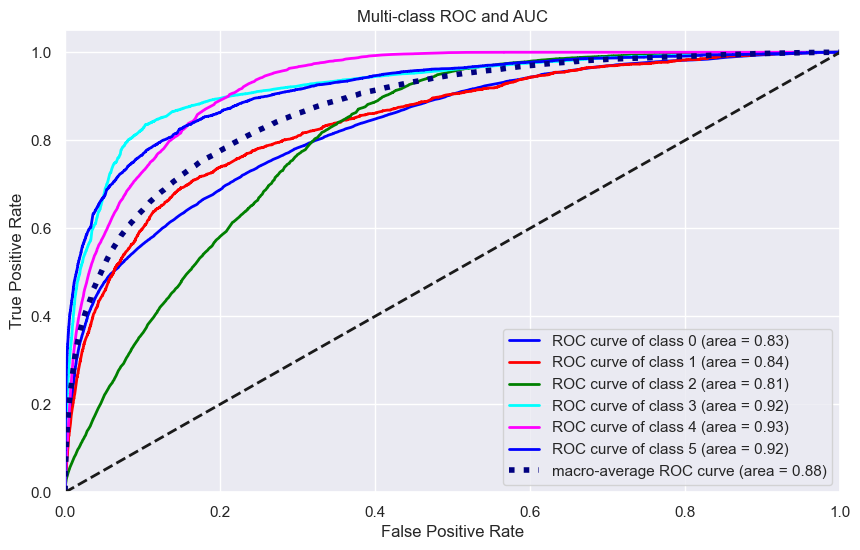

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# 计算每个类别的FPR和TPR
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)  # 类别的数量

# 计算每个类别的ROC曲线和AUC分数
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid, y_valid_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏观平均ROC曲线和AUC分数
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# 绘制宏观平均ROC曲线
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()
